In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



In [5]:
# data = pd.read_excel("data_test-1.xls", header=26, skiprows=0)
raw_data = pd.read_excel("python_data_2014.xls")
data = raw_data.copy()


In [6]:
data.shape

(3174, 254)

## Cleaning Data

In [7]:
data = data.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [8]:
# removing any unnamed columns
for col in data.columns:
    if 'Unnamed' in col:
        del data[col]

In [9]:
data.shape

(3174, 237)

In [10]:
data = data[data['MAT $ 2012'] != 0]
data = data[data['MAT $ 2013'] != 0]
data = data[data['MAT $ 2014'] != 0]
data.shape

(1519, 237)

## Adding Features

In [11]:
# mean of occ cost % over 3 years
data['avg_occ_3yrs'] = data[['MAT Occ Cost % 2012', 'MAT Occ Cost % 2013', \
                                     'MAT Occ Cost % 2014']].apply(np.sum, axis=1)/3

In [55]:
imp_feat_list = ['Lease', 'MAT $ CAGR ', 'MAT $ (mo. slope) ', 'avg_occ_3yrs', 'MAT $ PSF Var_Avg ', 'MAT $ PSF Var_slope ', \
                'MAT Occ Cost % (slope) ', 'MAT Occ Cost % CAGR ', 'MAT Occ Cost % CAGR to MAT $ Var ', 'MAT Occ Cost %_Avg_Var _2014',\
                'MAT Occ Cost %_1yr_slope _', 'MAT Occ Cost %_2yr_slope _', 'Month $ PSF % Var_1yr_avg _', 'Month $ PSF % Var_2yr_avg _',\
                'Month $ PSF % Var (1 yr. slope) _', 'Month $ PSF % Var (2 yr. slope) _', \
                'Holiday Month % Var _2014', 'Lease Term (mo.)', 'AR_Past_Due_MAX', 'AR_% of Billings Owed_MAX', \
                'AR_61 - 90_MAX', 'AR_Over 90_MAX', 'AR_2monthover_MAX','National Tenant Flag-Calc','Multi-Tenant Tag (>3)', 'Defaulted']

# removed:'Non-Holiday Month % Var _2013'

In [18]:
# data.head()

In [19]:
# print(data['Lease Space Type-Calc'].unique())
# INL_data = data[data['Lease Space Type-Calc'] == 'INL']
# print(INL_data['Space Type'].unique())
# INL_data[INL_data['Space Type'] == 'In-Line Units 0-9,999 SF']

In [39]:
# INL_data.head()

### Parsing Out Inline Tenants

In [56]:
INL_data = data[data['Lease Space Type-Calc'] == 'INL']
INL_data = INL_data[INL_data['Space Type'] == 'In-Line Units 0-9,999 SF']
INL_data = INL_data[INL_data['National Tenant Flag-Calc'] == 0]
INL_data = INL_data[INL_data['Multi-Tenant Tag (>3)'] == 0]

# below code if i want to include multiple tenant types
# stk_list = ['INL']
# INL_data = [data['Lease Space Type-Calc'].isin(stk_list)]

INL_data.shape

(547, 238)

In [57]:
# INL_data.columns.values

### % of tenants that have defaulted within Inline dataset

In [58]:
INL_DEF_Tenants = INL_data[INL_data['Defaulted'] == 1]
print("Number of leases in dataset: ", len(INL_data))
print("Number of defaulted leases in dataset: ", len(INL_DEF_Tenants))
default_percent = "{:.2f}%".format(len(INL_DEF_Tenants)/len(INL_data))  # percent of defaulted tenants in inline dataset
print("Percent of defaulted: ", default_percent)

Number of leases in dataset:  547
Number of defaulted leases in dataset:  45
Percent of defaulted:  0.08%


In [59]:
## sorts which malls have greatest number of defaults
pop_mall_defs = INL_data['BU Number-E1'].max()
print(pop_mall_defs)
INL_data[INL_data['BU Number-E1'] == pop_mall_defs]
print("Greatest number of defaults per mall is 2")


12327
Greatest number of defaults per mall is 2


## Logistic Regression Analysis

### SciKit Learn - Logistic Regression

In [60]:
# Import Logistic Regression & Linear regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score


In [66]:
## create data for logarithmic regression analysis
# log_list choooses categories I want to include in analysis
log_list = imp_feat_list
log_data = INL_data[log_list].copy()  # make sure to make copy so it's more than reference
log_data = log_data.drop('Lease', axis=1)  # drop lease from log_data
log_data = log_data.dropna(axis=0)  # remove any blank values from dataframe
# log_data

In [67]:
print(log_data.corr())  # looks at r^2 between 

                                   MAT $ CAGR   MAT $ (mo. slope)   \
MAT $ CAGR                            1.000000            0.507881   
MAT $ (mo. slope)                     0.507881            1.000000   
avg_occ_3yrs                         -0.230852           -0.119882   
MAT $ PSF Var_Avg                     0.621087            0.381657   
MAT $ PSF Var_slope                   0.138942            0.031296   
MAT Occ Cost % (slope)               -0.326241           -0.073378   
MAT Occ Cost % CAGR                   0.819238            0.307326   
MAT Occ Cost % CAGR to MAT $ Var      0.395981            0.375249   
MAT Occ Cost %_Avg_Var _2014         -0.378923           -0.176395   
MAT Occ Cost %_1yr_slope _           -0.214615           -0.040940   
MAT Occ Cost %_2yr_slope _           -0.231052           -0.058701   
Month $ PSF % Var_1yr_avg _           0.496355            0.094792   
Month $ PSF % Var_2yr_avg _           0.707364            0.336007   
Month $ PSF % Var (1

In [68]:
log_data_X = log_data.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
log_X = log_data_X.values  # turn datatable into array
log_y = log_data['Defaulted']  

In [69]:
# Fit logistic regression model
X_train_log, X_test_log, y_train_log, y_test_log = cross_validation.train_test_split(log_X, log_y, test_size=.5, random_state=0)

lr = LogisticRegression(C=1, max_iter=100, penalty='l2')  #l1: lasso l2: ridge regression
lr.fit(X_train_log, y_train_log)



/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [70]:
lr.coef_
sorted(list(zip(lr.coef_[0], log_data_X.columns)))  # pull most weighted coefficients with respective feature name

[(-0.77645676533793673, 'Holiday Month % Var _2014'),
 (-0.61116467202609559, 'avg_occ_3yrs'),
 (-0.39797673859329885, 'MAT $ PSF Var_Avg '),
 (-0.3393443814112807, 'MAT Occ Cost % CAGR to MAT $ Var '),
 (-0.24059804503871601, 'MAT $ CAGR '),
 (-0.21969494449274846, 'Month $ PSF % Var_1yr_avg _'),
 (-0.10369747885313603, 'Month $ PSF % Var_2yr_avg _'),
 (-0.02436366654587346, 'Lease Term (mo.)'),
 (-0.016803749296084844, 'Month $ PSF % Var (1 yr. slope) _'),
 (-0.016465208450558284, 'Month $ PSF % Var (2 yr. slope) _'),
 (-0.0085656537371863045, 'AR_% of Billings Owed_MAX'),
 (-4.5068523954816196e-05, 'AR_61 - 90_MAX'),
 (-1.1965028039380393e-05, 'MAT $ (mo. slope) '),
 (-2.8124719455559826e-06, 'AR_Over 90_MAX'),
 (0.0, 'Multi-Tenant Tag (>3)'),
 (0.0, 'National Tenant Flag-Calc'),
 (5.6870684112837251e-05, 'AR_Past_Due_MAX'),
 (0.0075426010259143058, 'MAT Occ Cost %_2yr_slope _'),
 (0.023187412984187493, 'MAT Occ Cost %_1yr_slope _'),
 (0.09874633637256465, 'MAT Occ Cost % CAGR '),
 

In [71]:
cross_val_score(lr, X_test_log, y_test_log)  # compares results of model to actual results

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getarg

array([ 0.91304348,  0.91208791,  0.87777778])

In [72]:
log_prob = lr.predict_proba(log_X)[:, 1]  # returns the probability
# print(log_prob)
log_pred_y = lr.predict(log_X)
list(zip(log_y, log_pred_y, log_prob))

[(1, 0, 0.3851872565313334),
 (1, 0, 0.087087311841514067),
 (1, 0, 0.42892899430078552),
 (1, 1, 0.63818881487253032),
 (1, 1, 0.53511775368805847),
 (1, 0, 0.093257668690365503),
 (1, 0, 0.20738069010346855),
 (1, 0, 0.14967314727264397),
 (1, 0, 0.058228007810737045),
 (1, 0, 0.25164009920099606),
 (1, 0, 0.32068326243806006),
 (1, 0, 0.1860889155738932),
 (1, 1, 0.72013048484243003),
 (1, 1, 0.59016241271948844),
 (1, 0, 0.203284542893447),
 (1, 0, 0.15513069448687566),
 (1, 0, 0.2857595417065768),
 (1, 0, 0.18979363138633829),
 (1, 0, 0.26901047064408989),
 (1, 1, 0.94413606211849854),
 (1, 1, 0.61989291845833028),
 (1, 1, 0.88768544413716999),
 (1, 1, 0.94145399593263657),
 (1, 0, 0.27070173949238868),
 (1, 1, 0.58298165985738803),
 (1, 1, 0.50130767621382288),
 (1, 0, 0.28367113515455372),
 (0, 0, 0.0175605682673186),
 (0, 0, 0.0052906111073530264),
 (0, 0, 0.02687975418862934),
 (0, 0, 0.004661679649999171),
 (0, 0, 0.092711495346182629),
 (0, 0, 0.071805402153315045),
 (0, 0, 

### GridSearch CV

In [75]:
# Thanks Tim and Jane for this code :)

from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(estimator=Ridge(), param_grid=dict(alpha=alphas), cv=5)
%time grid.fit(X_train_log, y_train_log)
print('Best Ridge alpha:', grid.best_estimator_.alpha)
print('Best Ridge score:', grid.best_score_)

from sklearn.linear_model import Ridge, Lasso
n_alphas = 200
alphas = np.linspace(-100, 1000, n_alphas)

score = []
for a in alphas:
   ridgelm = Ridge(alpha=a)
   ridgelm.fit(X_train_log, y_train_log)
   score.append(ridgelm.score(X_test_log, y_test_log))

plt.figure(figsize=(15, 10))
plt.xlabel('Alpha Parameter')
plt.ylabel('Ridge Score')
plt.title('Ridge Parameter Optimization')
plt.xlim(min(alphas)-1.1,max(alphas)+1.1)
plt.scatter(alphas,score);

NameError: name 'Ridge' is not defined

### Stats Models - Logistic Regression Analysis

In [76]:
# Statsmodel APIs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # uses R style formulas


In [77]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = cross_validation.train_test_split(log_X, log_y, test_size=.5, random_state=1)

In [89]:
# X_train = sm.add_constant(X_train_sm)
model = sm.Logit(y_train_sm, X_train_sm)
results = model.fit()


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [182]:
cross_val_score(lr, X_test_sm, y_test_sm)

array([ 0.92777778,  0.90555556,  0.90555556])

In [183]:
results = smf.Logit(log_y, log_X, data=log_data).fit()

Optimization terminated successfully.
         Current function value: 0.224023
         Iterations 12


In [184]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:              Defaulted   No. Observations:                 1080
Model:                          Logit   Df Residuals:                     1058
Method:                           MLE   Df Model:                           21
Date:                Mon, 09 Nov 2015   Pseudo R-squ.:                  0.1440
Time:                        16:35:23   Log-Likelihood:                -241.95
converged:                       True   LL-Null:                       -282.64
                                        LLR p-value:                 4.711e-09
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             3.6844   2.31e+07   1.59e-07      1.000     -4.53e+07  4.53e+07
x2          1.457e-06   3.16e-06      0.462      0.644     -4.73e-06  7.64e-06
x3            -5.4622      0.935     -5.845      0.0

In [185]:
sorted(list(zip(results.params, log_data_X.columns)))

[(-20.99874343816186, 'Month $ PSF % Var (2 yr. slope) _'),
 (-12.826683194380333, 'Month $ PSF % Var_2yr_avg _'),
 (-5.8160996304679236, 'MAT $ PSF Var_Avg '),
 (-5.4621685581314789, 'avg_occ_3yrs'),
 (-4.5282476874536801, 'MAT Occ Cost %_Avg_Var _2013'),
 (-3.8958722126436438, 'MAT $ PSF Var_slope '),
 (-1.5790000195128526, 'MAT Occ Cost % (slope) '),
 (-0.13013704713933688, 'Holiday Month % Var _2013'),
 (-0.021727378391393118, 'Lease Term (mo.)'),
 (1.4568361940777739e-06, 'MAT $ (mo. slope) '),
 (1.6193611766019542e-05, 'AR_Past_Due_MAX'),
 (2.2659220886932708e-05, 'AR_Over 90_MAX'),
 (4.2211537951801655e-05, 'AR_61 - 90_MAX'),
 (0.029889109639975799, 'AR_% of Billings Owed_MAX'),
 (0.20360834883118281, 'AR_2monthover_MAX'),
 (0.64987423555773149, 'Non-Holiday Month % Var _2013'),
 (0.91813166476273289, 'MAT Occ Cost % CAGR to MAT $ Var '),
 (2.7662647136655893, 'MAT Occ Cost % CAGR '),
 (3.6843904988963847, 'MAT $ CAGR '),
 (5.5714285704682496, 'Month $ PSF % Var (1 yr. slope) _'

# Random Forrest analysis

In [79]:
# import libraries

from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import DecisionTree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt



# Set a random seed.
rng = np.random.RandomState(0)

## try out test, train split b/c high accuracy score

In [90]:
tree_list = imp_feat_list
tree_data = INL_data[tree_list].copy()  # make sure to make copy so it's more than reference
tree_data = tree_data.drop('Lease', axis=1)
tree_data = tree_data.dropna(axis=0)
tree_data_X = tree_data.drop('Defaulted', axis=1)


In [91]:
tree_X = tree_data_X.values
tree_y = tree_data['Defaulted']
# tree_data

In [92]:
# splitting data so as to avoid overfitting
X_train_tree, X_test_tree, y_train_tree, y_test_tree = cross_validation.train_test_split(tree_X, \
                                                                                         tree_y, \
                                                                                         test_size=.3, \
                                                                                         random_state=1)

In [93]:
rf = RandomForestClassifier(n_estimators=500)
# rf.fit(tree_X, tree_y)
rf.fit(X_train_tree, y_train_tree)

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getarg

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [94]:
# to research

cross_val_score(rf, X_test_tree, y_test_tree)

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getarg

array([ 0.90909091,  0.92727273,  0.88888889])

In [95]:
tree_pred_y = rf.predict(tree_X)

In [97]:
list(zip(tree_y, tree_pred_y))

[(1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 0),
 (1, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 

## Find important classifiers

In [98]:
# Thanks Tim for the references

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


# variables for graph input
rand_imp_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rand_imp_feats = []
rand_imp_featnums = []

for f in range(10):
    
    # appending feature names to rand_imp_feats list
    feats = tree_data_X.columns[indices[f]]
    rand_imp_feats.append(feats)
    # appending feature values to rand_imp_featnums list
    featnums = importances[indices[f]]
    rand_imp_featnums.append(featnums)

    print("%d. feature %s (%f)" % (f + 1, tree_data_X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature AR_% of Billings Owed_MAX (0.077507)
2. feature AR_Past_Due_MAX (0.072230)
3. feature Holiday Month % Var _2014 (0.072095)
4. feature MAT Occ Cost % CAGR  (0.067347)
5. feature MAT $ CAGR  (0.061593)
6. feature Month $ PSF % Var (1 yr. slope) _ (0.060841)
7. feature AR_Over 90_MAX (0.060554)
8. feature Month $ PSF % Var_1yr_avg _ (0.059814)
9. feature Month $ PSF % Var_2yr_avg _ (0.059666)
10. feature MAT Occ Cost %_1yr_slope _ (0.046532)


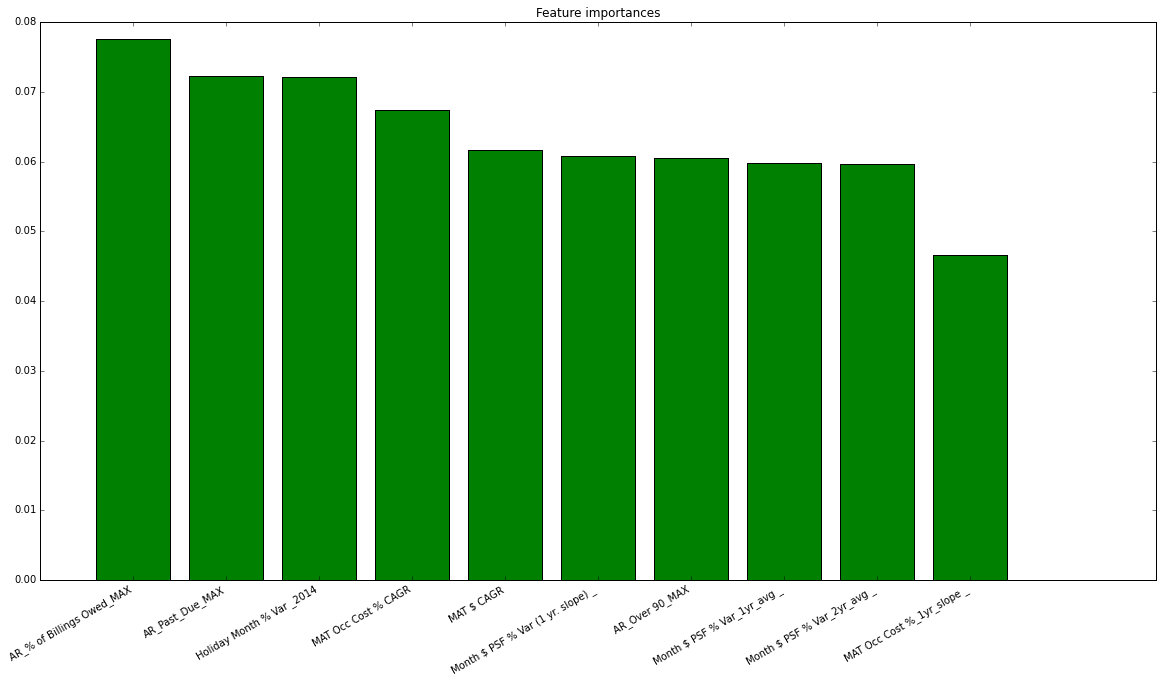

In [99]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(rand_imp_range, rand_imp_featnums,
       color="g", align="center")
plt.xticks(rand_imp_range, rand_imp_feats, rotation=30, ha='right')
plt.show()




## K-means Clustering

In [100]:
# import kmeans libraries
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

In [101]:
## create data for K-means clustering analysis
# k_list choooses categories I want to include in analysis
k_list = imp_feat_list
kmdata = INL_data[k_list].copy()  # make sure to make copy so it's more than reference
kmdata = kmdata.drop('Lease', axis=1)  # drop lease from log_data
kmdata = kmdata.dropna(axis=0)  # remove any blank values from dataframe

In [102]:
kmdata_X = kmdata.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
kmdata_X = kmdata_X.values  # turn datatable into array
kmdata_y = kmdata['Defaulted']  

In [103]:
##### cluster data into K=1..10 clusters #####
#K, KM, centroids,D_k,cIdx,dist,avgWithinSS = kmeans.run_kmeans(X,10)

K = range(1,100)

  # scipy.cluster.vq.kmeans
KM = [kmeans(kmdata_X,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(kmdata_X, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/kmdata_X.shape[0] for d in dist]

ValueError: object arrays are not supported

NameError: name 'avgWithinSS' is not defined

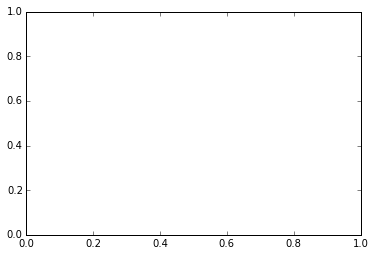

In [104]:
kIdx = 10
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

In [105]:
from sklearn.cluster import KMeans
km = KMeans(10, init='k-means++') # initialize
km.fit(kmdata_X)
c = km.predict(kmdata_X) # classify into three clusters

## Add cluster feature to data table

In [106]:
kmdata['cluster_num'] = c

# table below shows that defaulted tenants do not all get grouped together.
kmdata

MAT $ CAGR   MAT $ (mo. slope)   avg_occ_3yrs  MAT $ PSF Var_Avg   \
3       -0.457891       -22413.747083      0.414918           -0.262892   
4       -0.436434       -25654.100417      0.183486           -0.304166   
22      -0.406602       -15226.847917      0.435558           -0.302278   
23      -0.333995       -20968.725000      0.282766           -0.236462   
24      -0.031582        -2905.116667      0.128786           -0.055297   
37      -0.033321        -3394.784583      0.130457           -0.066113   
50      -0.122775       -13690.360417      0.227757           -0.099176   
53      -0.168582       -37627.217917      0.279440           -0.207658   
54      -0.070222        -1245.782917      0.746505           -0.013163   
55      -0.252197        -6967.528333      0.211885           -0.212713   
56      -0.737429       -33306.250000      0.385778           -0.392575   
57      -0.171583       -48227.166667      0.171606           -0.080543   
64      -0.439625       -25799.008333      0.233223           -0.296592   
67      -0.524478       -11501.332917      0.367907           -0.432828   
74      -0.140303        -7486.986250      0.201001           -0.020425   
76      -0.065961        -3113.320833      0.413167           -0.081870   
84      -0.731432       -17732.583333      0.421350           -0.327558   
88      -0.240392       -49925.050417      0.302132           -0.270057   
91      -0.487935       -51529.583333      0.172457           -0.315767   
96      -0.180924       -41842.431667      0.414710           -0.235680   
98      -0.643523       -20038.699583      0.497173           -0.393240   
121     -0.397425       -31895.872917      0.369045           -0.250575   
123     -0.821487       -10427.404583      0.992766           -0.295919   
128     -0.113335         -669.958333      0.322418            0.480378   
131     -0.234785        -3852.124583      0.298679            0.010513   
138      0.366922         3076.746667      0.237617            0.716119   
149     -0.157822        -4560.018333      0.297267           -0.119469   
187     -0.046234        -3750.631667      0.274013           -0.078437   
193      0.026328         2083.252500      0.323144            0.052266   
202     -0.009932        -4025.595833      0.236484            0.014649   
...           ...                 ...           ...                 ...   
2707     0.034467         2616.097500      0.281751            0.044655   
2709     0.002159          171.582083      0.390184           -0.025480   
2722    -0.171536       -29585.330417      0.244531           -0.162456   
2723    -0.052913        -7352.492083      0.406484           -0.074639   
2726     0.040966        26714.671667      0.105163            0.082073   
2739    -0.033152       -23053.843333      0.139657            0.003654   
2744    -0.050162        -8360.033750      0.221239           -0.059655   
2748     0.045773         5018.451250      0.194987            0.046681   
2751    -0.115614        -9564.280000      0.305614           -0.122958   
2757    -0.082985       -17112.920833      0.284618           -0.052054   
2762     0.060015        18255.041250      0.187958            0.075998   
2763    -0.022756        -1425.608333      0.227173           -0.044018   
2769     0.006433          655.041667      0.423918            0.014863   
2785     0.001752          300.082083      0.256260            0.047059   
2787    -0.012931        -1610.333333      0.173170            0.013823   
2790    -0.010181        -2011.262083      0.120878            0.011481   
2797     0.015239          833.333333      0.256773            0.081308   
2799    -0.029938       -30038.250417      0.083144           -0.060279   
2806    -0.066193        -3622.875000      0.605621           -0.090157   
2822     0.014892         4538.197083      0.285320            0.004677   
2875    -0.007291        -1121.023750      0.249790            0.842480   
2882     0.032631         6061.

In [107]:
# kmdata[kmdata['cluster_num'] == 0]

## Support Vector Machines

In [108]:
from sklearn import svm

In [109]:
## create data for K-means clustering analysis
# k_list choooses categories I want to include in analysis
svm_list = imp_feat_list
svmdata = INL_data[svm_list].copy()  # make sure to make copy so it's more than reference
svmdata = svmdata.drop('Lease', axis=1)  # drop lease from log_data
svmdata = svmdata.dropna(axis=0)  # remove any blank values from dataframe

In [110]:
outliers = svmdata[svmdata['Defaulted'] == 1]
inliers = svmdata[svmdata['Defaulted'] == 0]

In [111]:
# inlier data
inlier_svmdata_X = inliers.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
inlier_svmdata_X = inlier_svmdata_X.values  # turn datatable into array
inlier_svmdata_y = inliers['Defaulted']  

In [112]:
# inlier data
outlier_svmdata_X = outliers.drop('Defaulted', axis=1)  # remove defaulted column from dataframe
outlier_svmdata_X = outlier_svmdata_X.values  # turn datatable into array
outlier_svmdata_y = outliers['Defaulted']  

In [113]:
clf = svm.OneClassSVM(nu=0.5, kernel="rbf")
clf.fit(inlier_svmdata_X)

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0, kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [139]:
# cross_val_score(clf, svmdata_X, kmdata_y)

In [114]:
svm_pred_y = clf.predict(inlier_svmdata_X)

In [115]:
clf.get_params()

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


{'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 0.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.5,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [116]:
list(zip(inlier_svmdata_y, svm_pred_y))

[(0, 1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, -1.0),
 (0, 

## PCA - Dimension Reduction

In [117]:
from sklearn.decomposition import PCA

In [118]:
pca_list = imp_feat_list
pca_data = INL_data[pca_list].copy()  # make sure to make copy so it's more than reference
pca_data = pca_data.drop('Lease', axis=1)
pca_data = pca_data.dropna(axis=0)
pca_data_X = pca_data.drop('Defaulted', axis=1)

pca_X = pca_data_X.values
pca_y = pca_data['Defaulted']


In [119]:
# create the model and fit the data
pca = PCA(n_components=2)
X_r = pca.fit(pca_X).transform(pca_X)

In [120]:
# first component explains how much data is available (not lost)
pca.explained_variance_ratio_  

array([ 0.97979036,  0.0170294 ])

/Users/brianporter/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


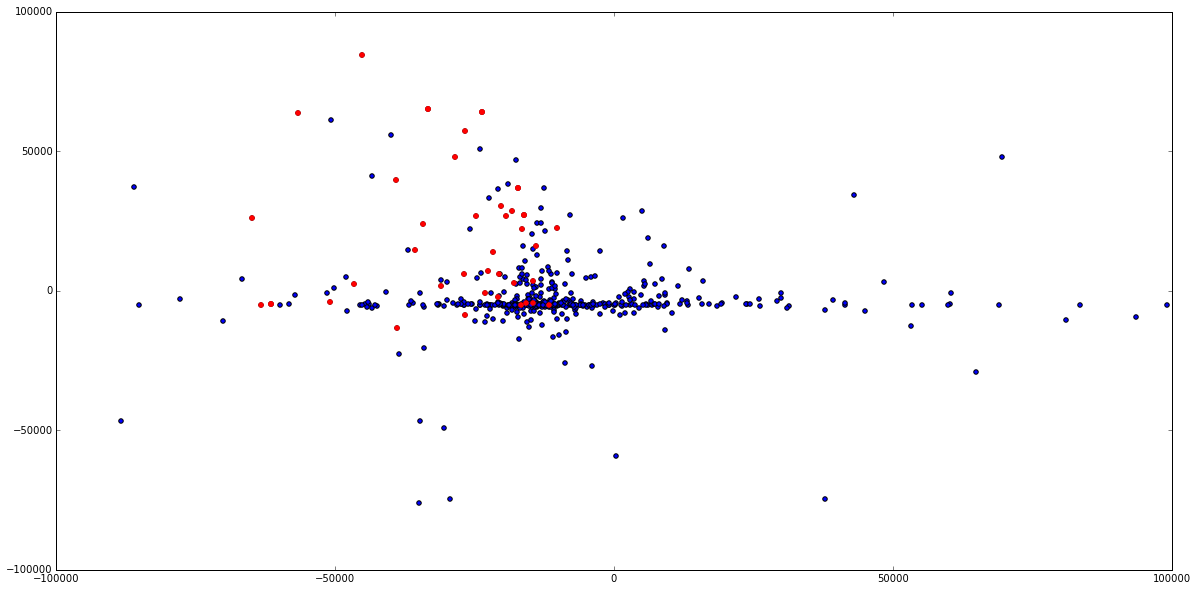

In [122]:
plt.figure(figsize=(20,10))
plt.xlim(-100000, 100000)
plt.ylim(-100000, 100000)
plt.scatter(X_r[:,0], X_r[:,1])


default_tens = []
for i, x in enumerate(pca_y):  #returns index in addition to the value of the index
    if x == 1:
#         print(X_r[i, 0], X_r[i, 1], pca_X[i])
        plt.scatter(X_r[i, 0], X_r[i, 1], color='r')
 

## LDA & QDA - Dimension Reduction

In [123]:
from sklearn.lda import LDA  # Linear Discriminant Analysis
from sklearn.qda import QDA  # Quadratic Discriminant Analysis

In [124]:
# create the model and fit the data
lda = LDA(n_components=3)
X_r2 = lda.fit(pca_X, pca_y).transform(pca_X)

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/lda.py:371: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [126]:
print(X_r2)

[[  2.64444467e+00]
 [  1.27308759e+00]
 [  2.75294548e+00]
 [  3.11028257e+00]
 [  2.34703085e+00]
 [  9.48456815e-02]
 [  7.07535771e-01]
 [  8.06986546e-01]
 [  2.03569586e-01]
 [  2.39795525e+00]
 [  3.22251492e+00]
 [  1.41539204e+00]
 [  3.08384717e+00]
 [  3.13109778e+00]
 [  2.00593366e+00]
 [  1.20954437e+00]
 [  2.75704577e+00]
 [  7.83788163e-01]
 [  2.23440362e+00]
 [  5.85718710e+00]
 [  4.30207070e+00]
 [  5.19405018e+00]
 [  6.56218817e+00]
 [  2.23543818e+00]
 [  2.65467876e+00]
 [  1.61156433e+00]
 [  2.02104587e+00]
 [  3.66013252e-01]
 [ -4.35205419e-01]
 [  1.69177504e-01]
 [ -7.31953393e-01]
 [  2.11947576e-01]
 [  6.39524386e-02]
 [ -3.77063507e-01]
 [ -1.79106887e+00]
 [ -8.61418414e-01]
 [  2.57461289e+00]
 [ -9.53449525e-02]
 [ -2.00212421e-01]
 [ -4.43166447e-02]
 [  1.14272994e+00]
 [ -7.11923060e-01]
 [ -1.17329068e+00]
 [  1.51924917e+00]
 [ -2.75686055e-01]
 [ -9.58880086e-01]
 [ -5.12998548e-01]
 [ -4.79557642e-02]
 [  4.24394390e-01]
 [ -1.19177298e+00]


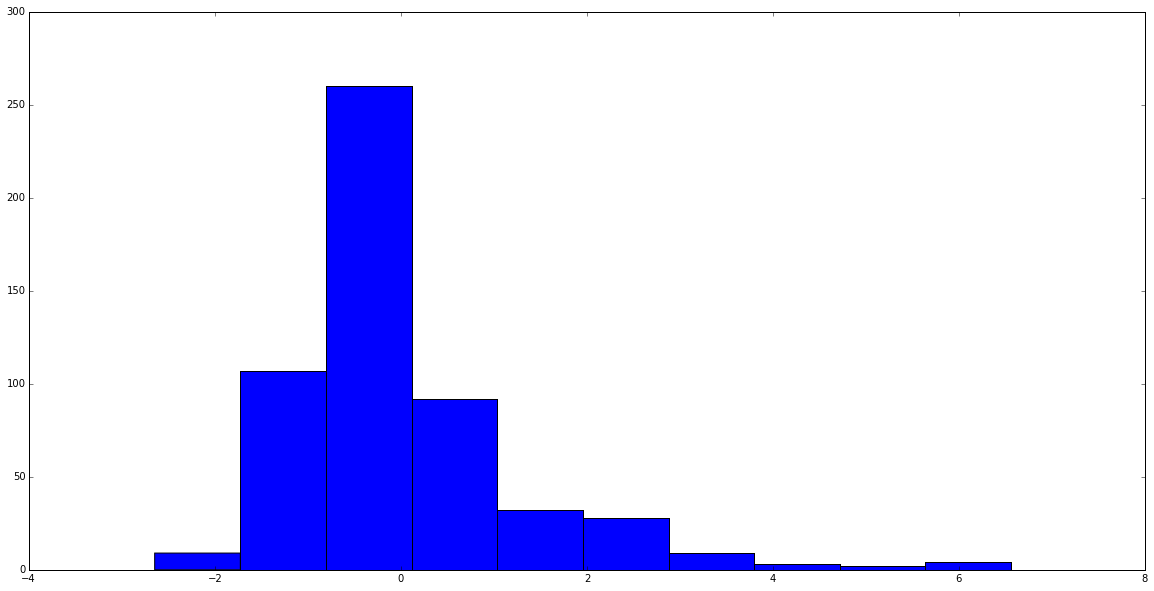

In [127]:
plt.figure(figsize=(20,10))
# plt.xlim(-100000, 100000)
# plt.ylim(-100000, 100000)
plt.hist(X_r2)
plt.show()


# for i, x in enumerate(pca_y):  #returns index in addition to the value of the index
#     if x == 1:
#         print(X_r2[i, 0], pca_X[i])
#         plt.hist(X_r2[i, 0], color='r')


In [128]:
# create the model and fit the data
qda = QDA()
X_r3 = qda.fit(pca_X, pca_y).predict(pca_X)

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/qda.py:133: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [84]:
# R^2 correlation between data features
# pca_data.corr()